# Trabalho 1 - PCA e KNN.         Nícolas Hecker Silva         RA: 186132

A primeira parte importante desse trabalho é baixar as dependencias necessárias usando pip, caso a máquina não as possua. Para isso usamos o código abaixo:

In [1]:
# instalar dependencias
!pip install pandas
!pip install jax
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install scikit-learn
!pip install matplotlib


Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


Agora podemos prosseguir para a primeira etapa.

# Obtendo os dados

Os dados utilizados nessa tarefa são do dataset de vinhos nativos do scikit learn datasets, por ser um dataset comumente utilizado para tentativas iniciais de algoritmos de aprendizado de máquina.
Vamos carregar e análisar como ele é

In [3]:
import pandas as pd
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Carregando o dataset Iris diretamente do scikit-learn
from sklearn.datasets import load_wine
wine = load_wine()

# Convertendo para um DataFrame do Pandas para facilitar a manipulação
data = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                    columns= wine['feature_names'] + ['target'])

# Convertendo para um array JAX se necessário para cálculos futuros
data_jax = jnp.array(data.values)

#imprimir o shape de data
print(data.shape)

# Exibindo as primeiras linhas do DataFrame
print(data.head())

print(np.unique(data["target"]))

(178, 14)
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0

Podemos ver que o dataset contém 178 amostras, cada uma com 14 características (features), usadas para reconhecer uma amostra de vinho.

As features presentes no dataset são:

- alcohol: Teor alcoólico do vinho.
- malic_acid: Conteúdo de ácido málico no vinho.
- ash: Conteúdo total de cinzas no vinho.
- alcalinity_of_ash: Alcalinidade das cinzas no vinho.
- magnesium: Conteúdo de magnésio no vinho.
- total_phenols: Conteúdo total de fenóis no vinho.
- flavanoids: Conteúdo de flavanóides no vinho.
- nonflavanoid_phenols: Conteúdo de não flavanóides no vinho.
- proanthocyanins: Conteúdo de proantocianidinas no vinho.
- color_intensity: Intensidade de cor do vinho.
- hue: Matiz do vinho.
- od280/od315_of_diluted_wines: Razão da densidade óptica a 280 nm para a densidade óptica a 315 nm de vinhos diluídos.
- proline: Conteúdo de prolina no vinho.

As classes desse dataset são 0, 1 e 2, e significam os locais onde esses vinhos foram feitos

Cada feature possui uma dimensão específica, variando mais ou menos que as outras, uma vez que possuem signficados diferentes. Plotar elas em um gráfico bidimensional seria interessante para poder visuzalizar bem como esses dados se comportam. Vamos tentar plotar as duas primeiras features para ver se existe alguma separação



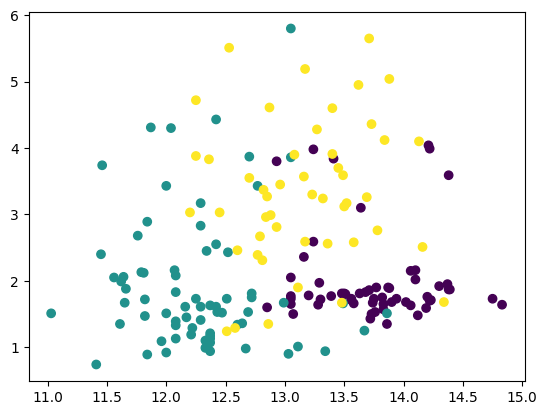

In [4]:
plt.scatter(data["alcohol"], data["malic_acid"], c=data["target"])
plt.show()
plt.close()

No quadro acima plotamos o álcool no eixo x e o ácido málico no eixo y. Suas unidades são distintas, mas a ferramenta matplotlib cuida de organizar a imagem de forma aceitável. Há grupos (aglomerados) visíveis no plot, mas ainda assim há muitos pontos de confusão, como o centro entre os três aglomerados. Nesse lugar não é possível classificar os pontos apenas pelas suas dua features. Mais ainda, há um ponto ao topo, no aglomerado amarelo, que é da classe azul, o que mostra que a sua classe seria classificada como amarelo, se fosse utilizado apenas essas duas features para classificar os pontos, muitos pontos seriam confundidos.

Vamos escolher outras duas features aleatoriamente.

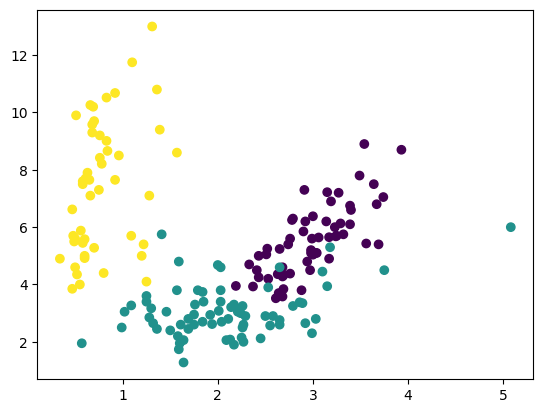

In [5]:
plt.scatter(data["flavanoids"], data["color_intensity"], c=data["target"])
plt.show()
plt.close()

Usando o flavonoids e a intensidade de cor, podemos ver uma divisão mais clara entre as classes, sendo facilmente separados os pontos atraves de seus aglomerados. Entretanto há uma pequena região em que os pontos roxos e azuis se mesclam, além de pontos azuis na parte direita da imagem que deveriam ser classificados como roxos. Esses pontos mesclados, poderiam estar entre os pontos separados das features anteriores, assim como em outras features relevantes. Vamos analisar o que ocorre com outras 3 features. Para isso será necessário adicionar o tamanho como um terceiro eixo.

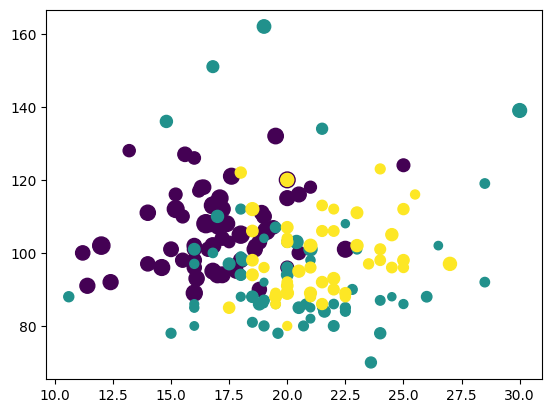

In [6]:
plt.scatter(data["alcalinity_of_ash"], data["magnesium"], s=data["proline"]//10, c=data["target"])
plt.show()
plt.close()

Aqui podemos ver que essas tres features não são facilmente separáveis. A dimensão do tamanho foi útil para diferenciar algumas amostras que tinha a mesma dimensão x,y, mas há alguns problemas: A ordem das asmotras pode impossibilitar que vejamos pontos peqenos atrás de pontos grandes. Não é muito fácil ver a divisão que ocorre no eixo do tamanho. Por fim, não existem muitas outras formad de representar outros eixos, ficando limitado a representar bem apenas 2 eixos. Para isso, podemos realizar uma operação que faz uma espécie de resumo através de projeções. Poderíamos projetar os dados em duas features principais constituídas de uma combinação das features mais relevantes. Como não sabemos quais features são mais relevantes para separar as amostras em cada momento, devemos utilizar uma projeção em dois eixos que carrega um pouco das informações de todos os eixos. Assim podemos utilizar uma técnica chamada PCA.
Entretanto, é necessário antes separar o dado em treino e teste.

In [7]:
#separa treino e teste
from sklearn.model_selection import train_test_split

X = data.drop('target', axis=1) # features
y = data['target'] # target

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=42)

# transforma em array
print(X_train_original)
X_train = jnp.array(X_train_original)
print(X_train[:, 17]) # imprime a primeira coluna do conjunto de treino
X_test = jnp.array(X_test_original)
y_train = jnp.array(y_train_original)
y_test = jnp.array(y_test_original)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
158    14.34        1.68  2.70               25.0       98.0           2.80   
137    12.53        5.51  2.64               25.0       96.0           1.79   
98     12.37        1.07  2.10               18.5       88.0           3.52   
159    13.48        1.67  2.64               22.5       89.0           2.60   
38     13.07        1.50  2.10               15.5       98.0           2.40   
..       ...         ...   ...                ...        ...            ...   
71     13.86        1.51  2.67               25.0       86.0           2.95   
106    12.25        1.73  2.12               19.0       80.0           1.65   
14     14.38        1.87  2.38               12.0      102.0           3.30   
92     12.69        1.53  2.26               20.7       80.0           1.38   
102    12.34        2.45  2.46               21.0       98.0           2.56   

     flavanoids  nonflavanoid_phenols  proanthocyan

Aqui separamos 80% dos dados para treino do knn e 20% para avaliação da qualidade do método. A divisão é aleatória com seed 42 para reprodutibilidade.

Agora podemos realizar o knn para verificar se, ao utilizar todas as features, podemos classificar corretamente os dados de teste utilizando apenas uma comparação com as amostras conhecidas utilizando métricas de distâncias.

Serão realizadas 2 funções de formas diferentes do knn para compará-los. A função native_knn utiliza a função knn implementada pelo sklearn para classificar os valores de test. A verificação é feita com a função de acuracia do sklearn, que apenas contabiliza o número de acertos dividido pelo número de erros. A segunda função knn calcula os testes dado uma métrica e calcula o teste por operações vetoriais. Vamos definir também uma classe métrica, que calcula a norma com pase em um produto interno dado. Outros produtos internos são definidos em sequencia 

# KNN

In [8]:
def native_knn(X_train, y_train, X_test, k):
    # funcao que utiliza o knn nativo como comparativo
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return y_pred

def evaluate(y_true, y_pred):
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_true, y_pred)
    

def knn(X_train, y_train, X_test, k, metric):
    # Para reazliar o knn, vamos 
    distances = jnp.array([[metric(x, x_train) for x_train in X_train] for x in X_test])
    min_distances = jnp.argsort(distances, axis=1)[:, :k] 
    palpites = jnp.array(y_train[min_distances], dtype=int)
    moda = jnp.array([jnp.bincount(palpite).argmax() for palpite in palpites])
    return moda

class Metrica():

    def __init__(self, produto_interno= jnp.dot):
        self.produto_interno = produto_interno


    def __call__(self, x, y):
        """
        Uma metrica de distancia calcula a distancia, um valor escalar, entre dois vetores dado
        um produto interno entre vetores. Um exemplo de produto interno é o dot product, utilizado como
        padrão nessa função.

        O produto interno será aplicado em x-y e x-y obtendo assim o quadrado da métrica. É então retornado
        a raiz quadrada do resultado.

        """
        return jnp.sqrt(self.produto_interno(x-y, x-y))

def produto_interno_crescente(x, y):
    # produz um vetor [1,2,3,4,5,6,7,8,9,...]
    importancia = jnp.arange(1, len(x)+1)
    return jnp.sum(importancia*x*y)


def produto_interno_decrescente(x, y):
    # produz um vetor [...,10,9,8,7,6,5,4,3,2,1]
    importancia = jnp.arange(len(x), 0, -1)
    return jnp.sum(importancia*x*y)

def produto_interno_apenas_impar(x, y):
    # produz um vetor [1,0,1,0,1,0,1,0,...]
    importancia = jnp.arange(1,len(x)+1) % 2
    return jnp.sum(importancia*x*y)


def produto_interno_apenas_primeiro(x, y):
    return x[0] * y[0]



Para realizar o knn foi calculado a distância entre todas as amostras do treino com todas as amostras do teste, e são selecionados as k amostras mais proximas de cada amostra de teste. Após isso é calculado a moda entre elas e a moda é atribuída como o resultado.

A métrica foi criada como uma classe para poder carregar com sigo a função do produto interno.

Depois disso são definidas os produtos internos:
- O primeiro atribui pesos crescentes aos valores dos vetores. O primeiro produto será multiplicado por 1, o segundo por 2, o terceiro por 3 e assim por diante.
- O segundo atribui pesos decrescentes aos valores dos vetores. Se o vetor possui 14 indices, o primeiro produto será multiplicado por 14, o segundo por 13, o terceiro por 12 e assim por diante.
- O terceiro considera apenas os indices ímpares, multiplicando por 0 todos os pares.
- O último leva em conta apenas o primeiro produto.

Mantendo o k = 3 podemos verificar o resultado do knn para as diferentes métricas, dente elas a euclideana, que utiliza o produto interno comum, e a manhatan, que não é definida como norma por algum produto interno.


In [9]:
manhattan = lambda x, y: jnp.sum(jnp.abs(x - y))
euclidean = lambda x, y: jnp.sqrt(jnp.sum((x - y) ** 2))




gk = knn(X_train, y_train, X_test, 3, euclidean)
print("acuracia do knn proprio",evaluate(y_test, gk))
knn_nativo = native_knn(X_train, y_train, X_test, 3)
print("acuracia do knn nativo como comparação de corretude",evaluate(y_test, knn_nativo))
gkm = knn(X_train, y_train, X_test, 3, manhattan)
print("acuracia do knn proprio com distância de manhattan",evaluate(y_test, gkm))




comum_knn = knn(X_train, y_train, X_test, 3, Metrica(lambda x, y: jnp.sum(x * y)))
print("acuracia do knn com metrica baseado em um produto interno comum",evaluate(y_test, comum_knn))
crescente_knn = knn(X_train, y_train, X_test, 3, Metrica(produto_interno_crescente))
print("acuracia do knn com metrica baseado em um produto interno que valoriza mais os primeiros valores dos vetores",evaluate(y_test, crescente_knn))
decrescente_knn = knn(X_train, y_train, X_test, 3, Metrica(produto_interno_decrescente))
print("acuracia do knn com metrica baseado em um produto interno que valoriza mais os últimos valores dos vetores",evaluate(y_test, decrescente_knn))
impar_knn = knn(X_train, y_train, X_test, 3, Metrica(produto_interno_apenas_impar))
print("acuracia do knn com metrica baseado em um produto interno que apenas considera indices impares dos vetores",evaluate(y_test, impar_knn))
primeiro_knn = knn(X_train, y_train, X_test, 3, Metrica(produto_interno_apenas_primeiro))
print("acuracia do knn com metrica baseado em um produto interno que valoriza apenas a primeira componente do vetor",evaluate(y_test, primeiro_knn))

acuracia do knn proprio 0.8055555555555556
acuracia do knn nativo como comparação de corretude 0.8055555555555556
acuracia do knn proprio com distância de manhattan 0.8333333333333334
acuracia do knn com metrica baseado em um produto interno comum 0.8055555555555556
acuracia do knn com metrica baseado em um produto interno que valoriza mais os primeiros valores dos vetores 0.8055555555555556
acuracia do knn com metrica baseado em um produto interno que valoriza mais os últimos valores dos vetores 0.7222222222222222
acuracia do knn com metrica baseado em um produto interno que apenas considera indices impares dos vetores 0.7777777777777778
acuracia do knn com metrica baseado em um produto interno que valoriza apenas a primeira componente do vetor 0.6944444444444444


Aqui podemos ver que a manhatan ajudou levemente a classificação knn, mas não há uma diferença significativa para distinguila do acaso por conta da distribuição dos dados.

Podemos ver também que atribuir pesos decrescentes, dando mais valor as primeiras features dos vetores foi mais interessanse para essas amostras do que dar mais peso para as últimas. Entretanto, isso ocorreu simplesmente por conta da ordem das features e suas relevancias na separação espacial, o que não é fácil de compreender sem realizar todos os testes ou ter um conhecimento de vinhos.

Podemos, pelo menos, verificar que considerar apenas a primeira feature gerou resultados significativamente piores que considerando as outras features, mas ainda assim, a acurácia está consideravelmente alta.

Agora podemos calcular diversas acurácias variando o k e mantendo a métrica como a euclideana para verificar para qual valor de k temos a maior acurácia.

In [10]:
acuracies1 = []
for i in range(1, 21):
    chutes = knn(X_train, y_train, X_test, i, euclidean)
    acuracies1.append(evaluate(y_test, chutes))


Podemos ver que o tempo desse cálculo foi de cerca de 40 segundos, o que é um tempo relevante, mas não muito alto como modelos profundos.

    Acuracia  Numero de vizinhos
0   0.777778                   1
1   0.722222                   2
2   0.805556                   3
3   0.750000                   4
4   0.722222                   5
5   0.722222                   6
6   0.694444                   7
7   0.722222                   8
8   0.722222                   9
9   0.722222                  10
10  0.750000                  11
11  0.722222                  12
12  0.722222                  13
13  0.722222                  14
14  0.750000                  15
15  0.722222                  16
16  0.777778                  17
17  0.777778                  18
18  0.777778                  19
19  0.777778                  20


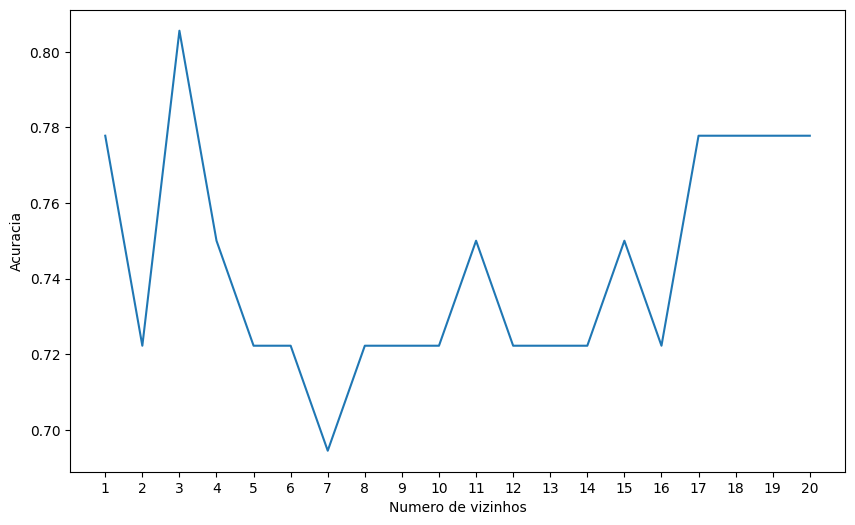

In [11]:
acuracies_df1 = pd.DataFrame(data=acuracies1, columns=['Acuracia'])
acuracies_df1['Numero de vizinhos'] = range(1, 21)
print(acuracies_df1)

plt.figure(figsize=(10, 6))
plt.plot(acuracies_df1['Numero de vizinhos'], acuracies_df1['Acuracia'])
plt.xlabel('Numero de vizinhos')
plt.ylabel('Acuracia')
# coloca 20 ticks no eixo x
plt.xticks(range(1, 21))
plt.show()
plt.close()

Com esse gráfico e tabela, podemos verificar que a diferença entre melhor desempenho e o pior foi de cerca de 10%. O ponto mais abaixo foi o k = 7 e o mais acima foi com k = 3. Isso possivelmente ocorreu pela relação entre densidade das amostras e o espalhamento das classes.

Não é possível ver um padrão muito claro nos valores de k e suas acurácias. Assim, as comparações principais serão feitas com k = 3.

Além disso, podemos ver que mesmo sem o pca, o knn pôde ter uma boa acurácia para esse problema.

Vamos ver agora a influencia dos diversos produtos internos na acurácia do knn.

In [12]:
new_acuracies0 = dict()
for produto in (produto_interno_crescente, produto_interno_decrescente, produto_interno_apenas_impar, produto_interno_apenas_primeiro):
    new_acuracies0[produto] = []
    for vizinhos in (1,3,7,20):
        chutes = knn(X_train, y_train, X_test, vizinhos, Metrica(produto))
        new_acuracies0[produto].append(evaluate(y_test, chutes))

podemos ver que o tempo desses loops encadeados ainda estão próximos aos 50 min, o que é aceitável para esse experimento

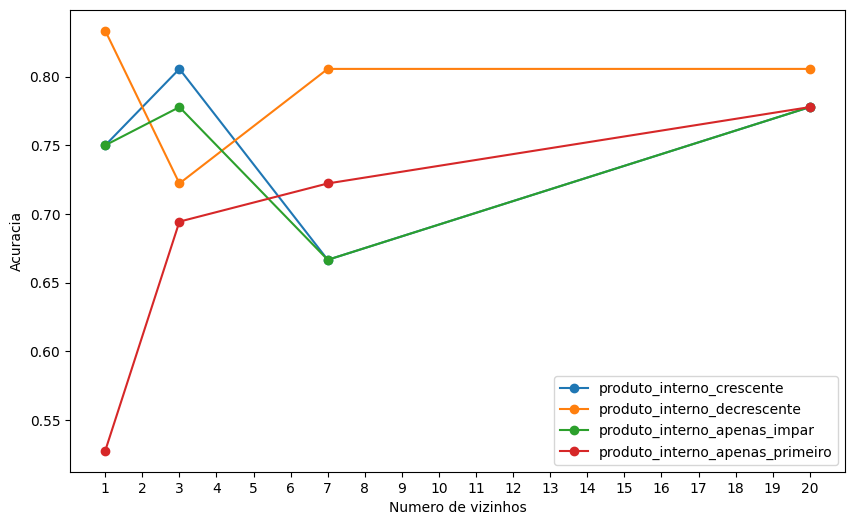

In [13]:
# plota as diversas metricas no mesmo grafico
plt.figure(figsize=(10, 6))
for produto in (produto_interno_crescente, produto_interno_decrescente, produto_interno_apenas_impar, produto_interno_apenas_primeiro):
    plt.plot((1,3,7,20), new_acuracies0[produto], label = produto.__name__, marker = "o")
plt.xlabel('Numero de vizinhos')
plt.ylabel('Acuracia')
plt.xticks(range(1, 21))
plt.legend()
plt.show()
plt.close()

Aqui já fica mais claro que embora para valores baixos de k, o produto interno que apenas considera a primeira componente é muito pior que os demais, entretanto quanto maior o valor de k, menor é a diferença entre todas os resultados com diferentes produtos internos.

Agora que conseguimos realizar corretamente o knn, vamos visualizar utilizando o PCA. Para isso vamos implementar o PCA utilizando o SVD e calculando os autovetores separadamente e por fim comparar com a implementação do sklearn.

# PCA e SVD

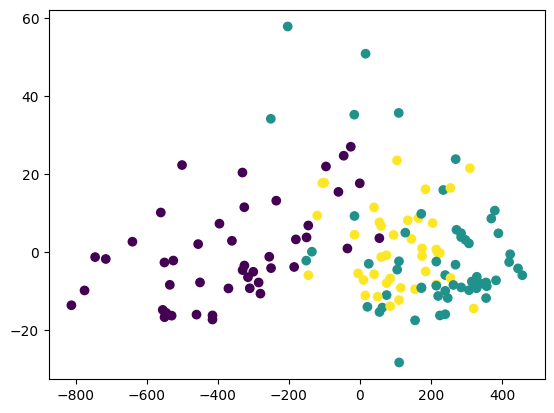

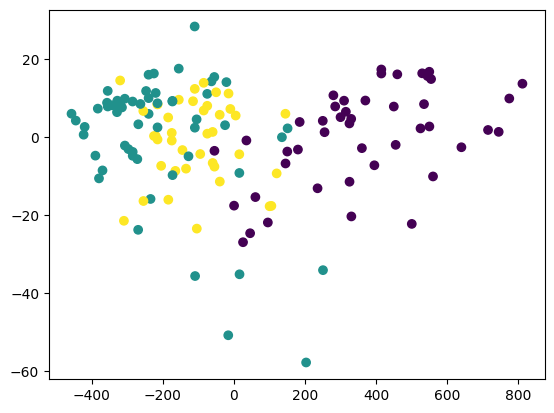

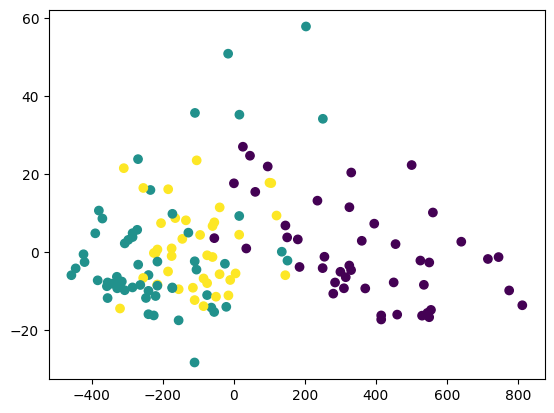

In [46]:
from jax.scipy.linalg import svd

def pca_sem_svd(data, num_components):
    data_centered = data - jnp.mean(data, axis=0)
    # Calcula a matriz de covariância
    cov_matrix = jnp.cov(data_centered, rowvar=False)
    # Calcula os autovalores e autovetores
    eigenvalues, eigenvectors = jnp.linalg.eigh(cov_matrix)
    # Ordena os autovetores de acordo com os autovalores
    idx = jnp.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    # Seleciona os num_components autovetores
    eigenvectors = eigenvectors[:, :num_components]
    # Transforma os dados originais
    return jnp.dot(data_centered, eigenvectors)



def pca(data, num_components):
    # Centralizar os dados
    data_centered = data - jnp.mean(data, axis=0)

    # Calcular a matriz de covariância
    cov_matrix = jnp.dot(data_centered.T, data_centered) / (data_centered.shape[0])

    # Calcular a SVD da matriz de covariância
    U, S, VT = jnp.linalg.svd(cov_matrix)

    # Selecionar os primeiros componentes principais
    principal_components = VT[:num_components]


    # Projetar os dados nos componentes principais
    novo_dado = jnp.dot(data_centered, principal_components.T)

    return novo_dado

    


pca_vec = pca(X_train, 2)


plt.scatter(pca_vec[:, 0], pca_vec[:, 1], c=y_train_original)
plt.show()

pca_vec_sem_svd = pca_sem_svd(X_train, 2)

plt.scatter(pca_vec_sem_svd[:, 0], pca_vec_sem_svd[:, 1], c=y_train_original)
plt.show()

from sklearn.decomposition import PCA

pca_calculer = PCA(n_components=2)
pca_calculer.fit(X_train_original)
X_train_pca = pca_calculer.transform(X_train_original)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_original)
plt.show()
plt.close()



Aqui podemos ver que a implementação com autovetores própria está levemente diferente, estando invertida sobre o eixo x e a primeira está invertida sobre o eixo y, mas com os módulos corretos em relação a última, a implementação do sklearn.

Os algoritmos consistem em centralizar a média dos dados na origem, subtraindo a média de todas as features em todos os dados. Após isso é calculando a matriz de covariância através do produto matricial da matriz centralizada com ela mesma, depois dividindo os valores pelo número de dados, o que se resume a uma média das amostras. Após isso, é calculado os autovetores e os ordenado, um pela função própria para isso e outro pela função do SVD. Dado o número principal_components como o número de componentes principais para o qual o PCA vai reduzir os dados, coletamos os principal_components's autovetores (da matriz VT) e usamos eles para multiplicar pelo dado centralizado. O resultado é o dado reduzido pelo PCA.

Vamos explorar um pouco as funções do SVD e o que ele nos retorna

In [15]:
def base_ortonormal(matrix):
    # Calcular a SVD
    U, sigma, VT = svd(matrix)
    return VT

ortNor = base_ortonormal(X_train)

produto = jnp.dot(ortNor, ortNor.T)

if jnp.allclose(produto, jnp.eye(produto.shape[1]), atol=1e-6):
    # se a norma é 1
    if jnp.allclose(jnp.linalg.norm(produto, axis=0), 1):
        print("A matriz é ortonormal, pois o módulo de suas colunas é 1 e A^T*A = I")
    else:
        print("A matriz é apenas ortogonal, pois o módulo de suas colunas não é 1, mas A^T*A = I")
else:
    print("A matriz não é ortonormal nem ortogonal, pois A^T*A != I")

# se o det é 0
if jnp.abs(jnp.linalg.det(ortNor)) < 1e-6:
    print("A matriz é linearmente dependente, portanto não é uma base")
else:
    print("A matriz é uma base, pois é linearmente independente")

print("A base tem shape ", ortNor.shape, " e a matriz original tem shape ", X_train.shape)

A matriz é ortonormal, pois o módulo de suas colunas é 1 e A^T*A = I
A matriz é uma base, pois é linearmente independente
A base tem shape  (13, 13)  e a matriz original tem shape  (142, 13)


O código acima possui uma função que retorna um candidato de base ortonormal de uma matriz qualquer. Para fazer isso, é utilizado o SVD, retornando a matriz da direita, ou seja, o VT.

Para checar se a matriz resultante é ortonormal, primeiro precisamos checar se ela é ortogonal. Para isso realizamos o produto dela por sua transposta e comparamos com a matriz identidade de mesma ordem. Como em computação a memória é finita, os valores são aproximados, o que gera um pequeno erro. Assim, é necessário o uso da função allclose para verificar se são iguais com uma tolearância. Isso poderia também ser feito com uma implementação própria, mas o uso dessas funções são mais otimizadas, garantindo velocidade, eficiencia energética e organização de código. Em seguida, se a matriz for ortogonal, ela ainda precisa que todos os seus vetores possuam norma 1. Para isso, calculamos a norma por linha e comparamos com 1. Se as duas propriedades valerem, a matriz é ortonormal, como é msotrado no resultado acima para a matriz de saída VT do SVD.

Após isso, precisamos verificar se a matriz é base. Para isso, todos os vetores precisam ser possíveis de serem gerado por ela (ou seja, precisam possuir a mesma natureza e dimensão). Além disso, os vetores dessa matriz precisam ser linearmente independentes, o que significa que o determinante precisa ser diferente de 0, o que ocorre também para a matriz VT. Assim, temos que VT é base do espaço vetorial das amostras do dataset, uma vez que sua dimensão é 13x13 linearmente independentes, e as amostras possuem 13 features.

Vamos verificar agora os cenários de projeção.

In [16]:
def obter_matriz_projecao(base):
    return jnp.dot(base, base.T)

def verificar_matriz_projecao(matriz_projecao):
    if jnp.allclose(matriz_projecao, matriz_projecao @ matriz_projecao, atol=1e-6):
        print("A matriz pode ser uma matriz de projeção, pois P^2 = P")
    else:
        print("A matriz não pode ser uma matriz de projeção, pois P^2 != P")
        return False
    if jnp.allclose(matriz_projecao, matriz_projecao.T, atol=1e-6):
        print("A matriz é uma matriz de projeção, pois P^T = P, ou seja, é simétrica")
        return True
    return False

matriz_projecao = obter_matriz_projecao(ortNor)
_ = verificar_matriz_projecao(matriz_projecao)

A matriz pode ser uma matriz de projeção, pois P^2 = P
A matriz é uma matriz de projeção, pois P^T = P, ou seja, é simétrica


# KNN com PCA

(178, 13)
(142, 2) (36, 2)


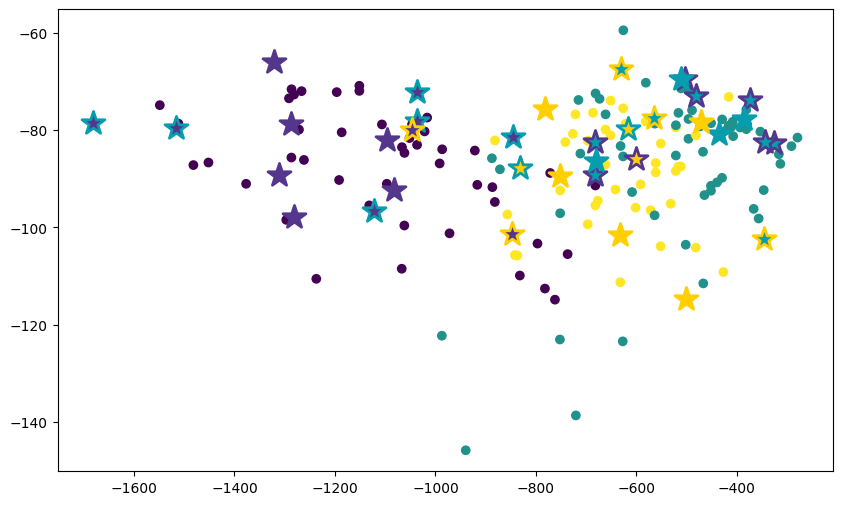

In [17]:
concatenado = jnp.concatenate((X_train, X_test), axis=0)
print(concatenado.shape)

# calcula o pca
pca_vec_conc = pca(concatenado, 2)

pca_train, pca_test = pca_vec_conc[:X_train.shape[0]], pca_vec_conc[X_train.shape[0]:]
print(pca_train.shape, pca_test.shape)

"""
cores = {0:'#069DAE', 1: '#FFCF00', 2:'#54378D'}
# deixa o plot maior
plt.figure(figsize=(10, 7))
#plota pca_train com bolinhas e suas classes
plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y_train_original)
# plota pca_test com * e suas classes, alem de borda e tamanho 10
plt.sca
plt.scatter(pca_test[:, 0], pca_test[:, 1], c=y_test_original, marker='*', edgecolors="black", linewidth=1, s=300)
plt.show()
# printa as cores usadas
"""


def plot(x_train, y_train, x_test, y_test, chutes):
    cores = {1.0:'#069DAE', 2.0: '#FFCF00', 0.0:'#54378D'}
    # Criar o gráfico de dispersão
    plt.figure(figsize=(10, 6))
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
    for c in np.unique(y_test):
        for ch in np.unique(chutes):
            mask = jnp.array((y_test == c) & (chutes == ch))
            # if jnp.sum(mask) == 0:
            #     continue
            plt.scatter(x_test[mask,0], x_test[mask,1], 
                        color=cores[c], 
                        edgecolor=cores[ch], 
                        linewidth=2,  
                        alpha=1.0, marker='*', s=300)

    plt.show()
    plt.close()

chutes = np.random.randint(0, 3, y_test_original.shape[0]).astype(float)
plot(pca_train, y_train_original, pca_test, y_test_original, chutes)

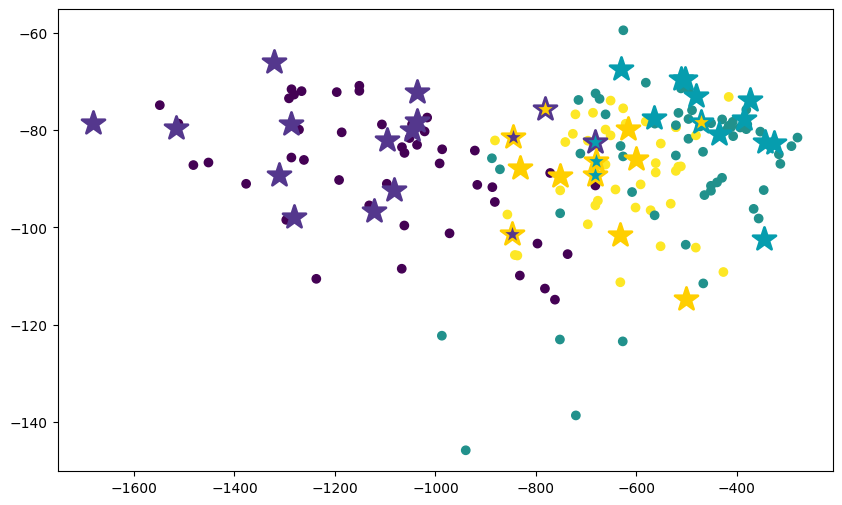

acuracia do knn proprio 0.8055555555555556


In [18]:
chutes = knn(X_train, y_train, X_test, 3, euclidean)
plot(pca_train, y_train_original, pca_test, y_test_original, chutes)
print("acuracia do knn proprio",evaluate(y_test, chutes))

In [19]:
acuracies = []
for i in range(1, 21):
    chutes = knn(X_train, y_train, X_test, i, euclidean)
    acuracies.append(evaluate(y_test, chutes))


    Acuracia  Numero de vizinhos
0   0.777778                   1
1   0.722222                   2
2   0.805556                   3
3   0.750000                   4
4   0.722222                   5
5   0.722222                   6
6   0.694444                   7
7   0.722222                   8
8   0.722222                   9
9   0.722222                  10
10  0.750000                  11
11  0.722222                  12
12  0.722222                  13
13  0.722222                  14
14  0.750000                  15
15  0.722222                  16
16  0.777778                  17
17  0.777778                  18
18  0.777778                  19
19  0.777778                  20


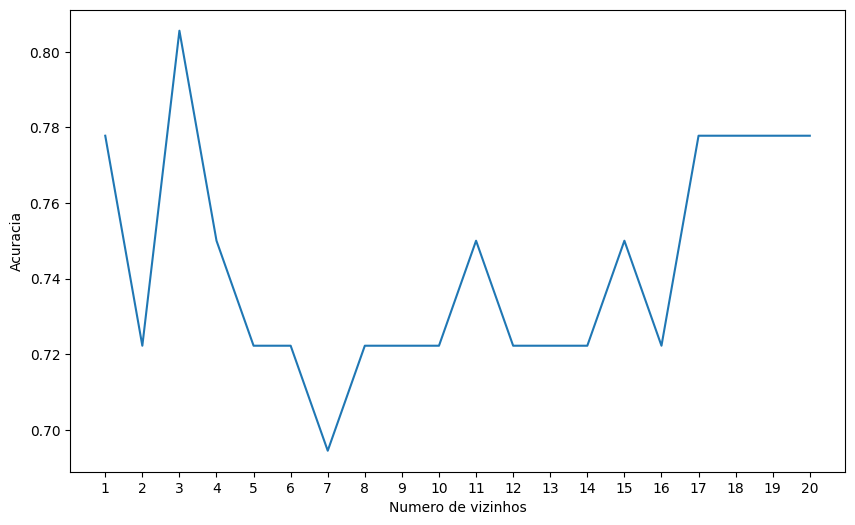

In [20]:
acuracies_df = pd.DataFrame(data=acuracies, columns=['Acuracia'])
acuracies_df['Numero de vizinhos'] = range(1, 21)
print(acuracies_df)

plt.figure(figsize=(10, 6))
plt.plot(acuracies_df['Numero de vizinhos'], acuracies_df['Acuracia'])
plt.xlabel('Numero de vizinhos')
plt.ylabel('Acuracia')
# coloca 20 ticks no eixo x
plt.xticks(range(1, 21))
plt.show()
plt.close()

In [21]:
new_acuracies = dict()
for produto in (produto_interno_crescente, produto_interno_decrescente, produto_interno_apenas_impar, produto_interno_apenas_primeiro):
    new_acuracies[produto] = []
    for vizinhos in (1,3,7,20):
        chutes = knn(X_train, y_train, X_test, vizinhos, Metrica(produto))
        new_acuracies[produto].append(evaluate(y_test, chutes))

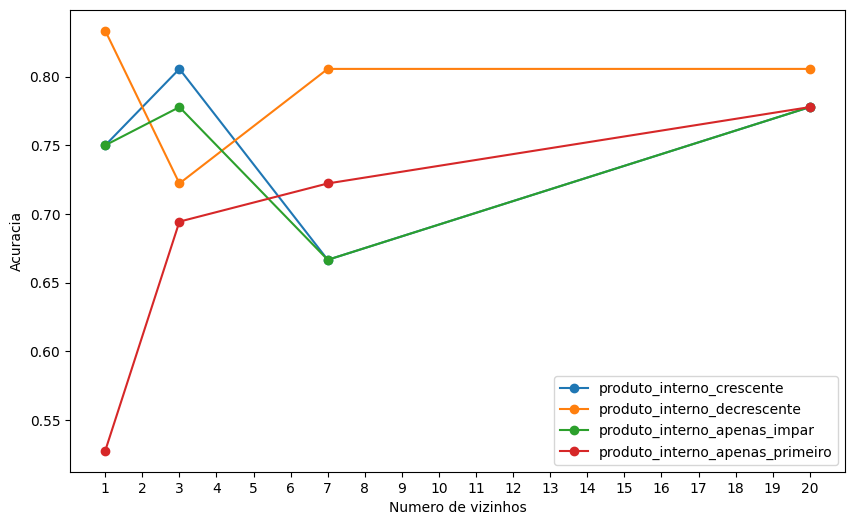

In [22]:
# plota as diversas metricas no mesmo grafico
plt.figure(figsize=(10, 6))
for produto in (produto_interno_crescente, produto_interno_decrescente, produto_interno_apenas_impar, produto_interno_apenas_primeiro):
    plt.plot((1,3,7,20), new_acuracies[produto], label = produto.__name__, marker = "o")
plt.xlabel('Numero de vizinhos')
plt.ylabel('Acuracia')
plt.xticks(range(1, 21))
plt.legend()
plt.show()
plt.close()

In [23]:
#mostrar tabela com acuracies_df e acuracies_df1
tabela_composta = pd.concat([acuracies_df, acuracies_df1], axis=1)
# 
# numero de vizinhos é o mesmo, então podemos remover uma das colunas
tabela_composta = tabela_composta.drop(columns=['Numero de vizinhos'])
print(tabela_composta)

    Acuracia  Acuracia
0   0.777778  0.777778
1   0.722222  0.722222
2   0.805556  0.805556
3   0.750000  0.750000
4   0.722222  0.722222
5   0.722222  0.722222
6   0.694444  0.694444
7   0.722222  0.722222
8   0.722222  0.722222
9   0.722222  0.722222
10  0.750000  0.750000
11  0.722222  0.722222
12  0.722222  0.722222
13  0.722222  0.722222
14  0.750000  0.750000
15  0.722222  0.722222
16  0.777778  0.777778
17  0.777778  0.777778
18  0.777778  0.777778
19  0.777778  0.777778
